In [ ]:
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy
import mplhep as hep

import pandas

In [ ]:
def flatten(arr):
    return arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2]))

In [ ]:
def cms_label(x0=0.12, x1=0.23, x2=0.67, y=0.90):
    plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=12)
    plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=10)
    plt.figtext(x2, y,'Run 3 (14 TeV), $\mathrm{t}\overline{\mathrm{t}}$ events',  wrap=False, horizontalalignment='left', fontsize=10)

def sample_label(ax, x=0.03, y=0.98):
    plt.text(x, y, "$\mathrm{t}\overline{\mathrm{t}}$ events", va="top", ha="left", size=10, transform=ax.transAxes)


In [ ]:
def apply_thresholds_f(ypred_raw_f, thresholds):
    msk = np.ones_like(ypred_raw_f)
    for i in range(len(thresholds)):
        msk[:, i+1] = ypred_raw_f[:, i+1]>thresholds[i]
    ypred_id_f = np.argmax(ypred_raw_f*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw_f, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, -1] - best_2[:, -2])
#     ypred_id_f[diff<0.05] = 0
    
    return ypred_id_f

def apply_thresholds(ypred_raw, thresholds):
    msk = np.ones_like(ypred_raw)
    for i in range(len(thresholds)):
        msk[:, :, i+1] = ypred_raw[:, :, i+1]>thresholds[i]
    ypred_id = np.argmax(ypred_raw*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, :, -1] - best_2[:, :, -2])
#     ypred_id[diff<0.05] = 0
    
    return ypred_id

In [ ]:
pid_names = {
    1: "ch.had",
    2: "n.had",
    3: "HFEM",
    4: "HFHAD",
    5: "g",
    6: "el",
    7: "mu"
}

pid_names_long = {
    1: "charged hadrons",
    2: "neutral hadrons",
    3: "HFEM",
    4: "HFHAD",
    5: "photons",
    6: "electrons",
    7: "muons"
}

var_names = {
    1: "charge",
    2: "pt",
    3: "eta",
    4: "sin phi",
    5: "cos phi",
    6: "energy"
}

x_labels = [
    "track", "PS1", "PS2", "ECAL", "HCAL", "GSF", "BREM", "HFEM", "HFHAD", "SC", "HO"
]
y_labels = [pid_names[i] for i in range(1,8)]

In [ ]:
path = "../experiments/cms-gnn-dense-a301aa09.gpu0.local/"

In [ ]:
Xs = []
ygens = []
ycands = []
ypreds = []
ypreds_raw = []
for fi in glob.glob(path + "/pred_batch*.npz")[:100]:
    dd = np.load(fi)
    Xs.append(dd["X"])
    ygens.append(dd["ygen"])
    ycands.append(dd["ycand"])
    ypreds.append(dd["ypred"])
    ypreds_raw.append(dd["ypred_raw"])

X = np.concatenate(Xs)
msk_X = X[:, :, 0]!=0

ygen = np.concatenate(ygens)
ycand = np.concatenate(ycands)
ypred = np.concatenate(ypreds)
ypred_raw = np.concatenate(ypreds_raw)

X_f = X.reshape((X.shape[0]*X.shape[1], X.shape[2]))
msk_X_f = X_f[:, 0]!=0
ygen_f = ygen.reshape((ygen.shape[0]*ygen.shape[1], ygen.shape[2]))
ycand_f = ycand.reshape((ycand.shape[0]*ycand.shape[1], ycand.shape[2]))
ypred_f = ypred.reshape((ypred.shape[0]*ypred.shape[1], ypred.shape[2]))
ypred_raw_f = ypred_raw.reshape((ypred_raw.shape[0]*ypred_raw.shape[1], ypred_raw.shape[2]))

In [ ]:
glob_iter = 0
def multiplicity_score(thresholds):
    global glob_iter
    ypred_id = apply_thresholds(ypred_raw, thresholds)
    total_scores = []
    for icls in range(1,8):
        ntrue = np.sum((ycand[:, :, 0]==icls)*msk_X, axis=1)
        npred = np.sum((ypred_id==icls)*msk_X, axis=1)
        diff = np.sqrt(np.sum((ntrue-npred)**2))/np.mean(ntrue)
        total_scores.append(diff)
        #print("  ", icls, np.mean(ntrue), np.mean(npred), diff)
    glob_iter += 1
    if glob_iter%10 == 0:
        print(glob_iter, np.sum(total_scores))
        print(",\t".join(["{:.2f}".format(x) for x in thresholds]))
        print(",\t".join(["{:.2f}".format(x) for x in total_scores]))
    return np.sum(total_scores)

ret = scipy.optimize.minimize(
    multiplicity_score,
    0.5*np.ones(7),
    tol=1e-5,
    method="Powell",
    bounds=[(0,1) for i in range(7)],
    #options={"ftol": 1e-6, "disp":True}
)

In [ ]:
thresholds = ret.x

In [ ]:
ypred_id = apply_thresholds(ypred_raw, thresholds)
ypred_id_f =  apply_thresholds_f(ypred_raw_f, thresholds)

In [ ]:
sklearn.metrics.balanced_accuracy_score(ycand_f[msk_X_f, 0], ypred_f[:, 0][msk_X_f])

In [ ]:
sklearn.metrics.balanced_accuracy_score(ycand_f[msk_X_f, 0], ypred_id_f[msk_X_f])

In [ ]:
for icls in range(1,8):
    npred = np.sum(ypred_id == icls, axis=1)
    ncand = np.sum(ycand[:, :, 0] == icls, axis=1)
    plt.figure(figsize=(6,6))
    plt.scatter(ncand, npred, marker=".", alpha=0.8)
    a = 0.5*min(np.min(npred), np.min(ncand))
    b = 1.5*max(np.max(npred), np.max(ncand))
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.plot([a,b],[a,b], color="black", ls="--")
    plt.title(pid_names_long[icls],y=1.05)
    plt.xlabel("number of PFCandidates")
    plt.ylabel("number of MLPFCandidates")
    cms_label(x2=0.6, y=0.89)
    plt.savefig("num_cls{}.pdf".format(icls))


In [ ]:
def load_history(path, max_epoch=None):
    ret = {}
    for fi in glob.glob(path):
        data = json.load(open(fi))
        epoch = int(fi.split("_")[-1].split(".")[0])
        ret[epoch] = data
    
    if not max_epoch:
        max_epoch = max(ret.keys())
    ret2 = []
    for i in range(max_epoch):
        ret2.append(ret[i])
    return pandas.DataFrame(ret2)

In [ ]:
history = load_history(path + "/history_*.json")

In [ ]:
def loss_plot(train, test, margin=0.05):
    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    p0 = plt.plot(train, alpha=0.2)
    p1 = plt.plot(test, alpha=0.2)
    
    train_smooth = np.convolve(train, np.ones(5)/5, mode='valid')
    plt.plot(train_smooth, color=p0[0].get_color(), lw=2, label="train")
    test_smooth = np.convolve(test, np.ones(5)/5, mode='valid')
    plt.plot(test_smooth, color=p1[0].get_color(), lw=2, label="test")
    
    plt.ylim(test[-1]*(1.0-margin), test[-1]*(1.0+margin))
    plt.legend(loc="best", frameon=False)
    plt.xlabel("epoch")
    cms_label(x1=0.18)
    #sample_label(ax, x=0.03, y=0.10)

In [ ]:
p0 = loss_plot(history["loss"].values, history["val_loss"].values)
plt.ylabel("Total loss")
plt.savefig("loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["cls_loss"].values, history["val_cls_loss"].values, margin=0.05)
plt.ylabel("Multiclassification loss")
plt.savefig("cls_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["energy_loss"].values, history["val_energy_loss"].values, margin=0.05)
plt.ylabel("Energy loss")
plt.savefig("energy_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["pt_loss"].values, history["val_pt_loss"].values, margin=0.1)
plt.ylabel("$p_T$ loss")
plt.savefig("pt_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["sin_phi_loss"].values, history["val_sin_phi_loss"].values, margin=0.01)
plt.ylabel("$\sin \phi$ loss")
plt.savefig("sin_phi_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["cos_phi_loss"].values, history["val_cos_phi_loss"].values, margin=0.01)
plt.ylabel("$\cos \phi$ loss")
plt.savefig("cos_phi_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["eta_loss"].values, history["val_eta_loss"].values, margin=0.01)
plt.ylabel("$\eta$ loss")
plt.savefig("eta_loss.pdf", bbox_inches="tight")

In [ ]:
p0 = loss_plot(history["charge_loss"].values, history["charge_loss"].values, margin=0.005)
plt.ylabel("charge loss")
plt.savefig("charge_loss.pdf", bbox_inches="tight")

In [ ]:
for icls in range(1,8):
    fig = plt.figure()
    ax = plt.axes()
    msk = (ycand_f[:, 0] == icls)
    plt.hist(ypred_raw_f[msk & (X_f[:, 0] != 0), icls], bins=100, density=1, histtype="step", lw=2, color="blue", label="true "+pid_names[icls]);
    plt.hist(ypred_raw_f[~msk & (X_f[:, 0] != 0), icls], bins=100, density=1, histtype="step", lw=2, color="red", label="other particles");
    #plt.axvline(ret.x[icls-1], 0, 0.7, ls="--",
    #    color="black", label="threshold: {:.2f}".format(ret.x[icls-1]), lw=1)
    plt.yscale("log")
    plt.title("Particle reconstruction for {}".format(pid_names[icls]), y=1.05)
    plt.xlabel("Classification output {}".format(icls))
    plt.ylabel("Normalized number of particles [a.u.]")
    plt.legend(loc=2, frameon=False)
    plt.ylim(1e-2, 1e4)
    cms_label(x1=0.2, x2=0.6)
    plt.savefig("cls_output_{}.pdf".format(icls))

In [ ]:
#perm = np.random.permutation(ycand_f[msk_X].shape[0])[:100000]

cm_norm = sklearn.metrics.confusion_matrix(
    ycand_f[msk_X_f & (ycand_f[:, 0]!=0), 0],
    ypred_id_f[msk_X_f & (ycand_f[:, 0]!=0)],
    labels=range(1,8),
    normalize="true"
)

cm = sklearn.metrics.confusion_matrix(
    ycand_f[msk_X_f & (ycand_f[:, 0]!=0), 0],
    ypred_id_f[msk_X_f & (ycand_f[:, 0]!=0)],
    labels=range(1,8),
)

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.imshow(cm_norm, cmap="Blues")
plt.colorbar()

cms_label(x1=0.18, x2=0.52, y=0.82)
#sample_label(ax, x=0.8, y=1.0)
plt.xticks(range(len(y_labels)), y_labels);
plt.yticks(range(len(y_labels)), y_labels);
plt.xlabel("Predicted PFCandidate")
plt.ylabel("True PFCandidate")
plt.title("MLPF trained on PF", y=1.03)
#plt.tight_layout()
plt.savefig("cm_normed.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.imshow(cm, cmap="Blues")
plt.colorbar()

cms_label(x1=0.18, x2=0.52, y=0.82)
#sample_label(ax, x=0.8, y=1.0)
plt.xticks(range(len(y_labels)), y_labels);
plt.yticks(range(len(y_labels)), y_labels);
plt.xlabel("Predicted PFCandidate")
plt.ylabel("True PFCandidate")
plt.title("MLPF trained on PF", y=1.03)
plt.savefig("cm.pdf", bbox_inches="tight")

In [ ]:
bins = {
    2: np.linspace(0,100,100),
    3: np.linspace(-8,8,100),
    4: np.linspace(-1,1,100),
    5: np.linspace(-1,1,100),
    6: np.linspace(0,500,100),
}

In [ ]:
for icls in range(1,8):
    for ivar in range(2,7):
        plt.figure()
        ax = plt.axes()
        b = bins[ivar]
        #plt.hist(ygen_f[ygen_f[:, 0]==icls, ivar], bins=b, histtype="step", lw=2, label="gen");
        plt.hist(ycand_f[ycand_f[:, 0]==icls, ivar], bins=b, histtype="step", lw=2, label="PF");
        plt.hist(ypred_f[ypred_id_f==icls, ivar], bins=b, histtype="step", lw=2, label="MLPF");
        plt.yscale("log")
        plt.legend()
        plt.title(pid_names_long[icls], y=1.05)
        plt.xlabel(var_names[ivar])
        plt.ylabel("Number of particles")
        cms_label(x1=0.2, x2=0.6)
        plt.savefig("distribution_icls{}_ivar{}.pdf".format(icls, ivar))

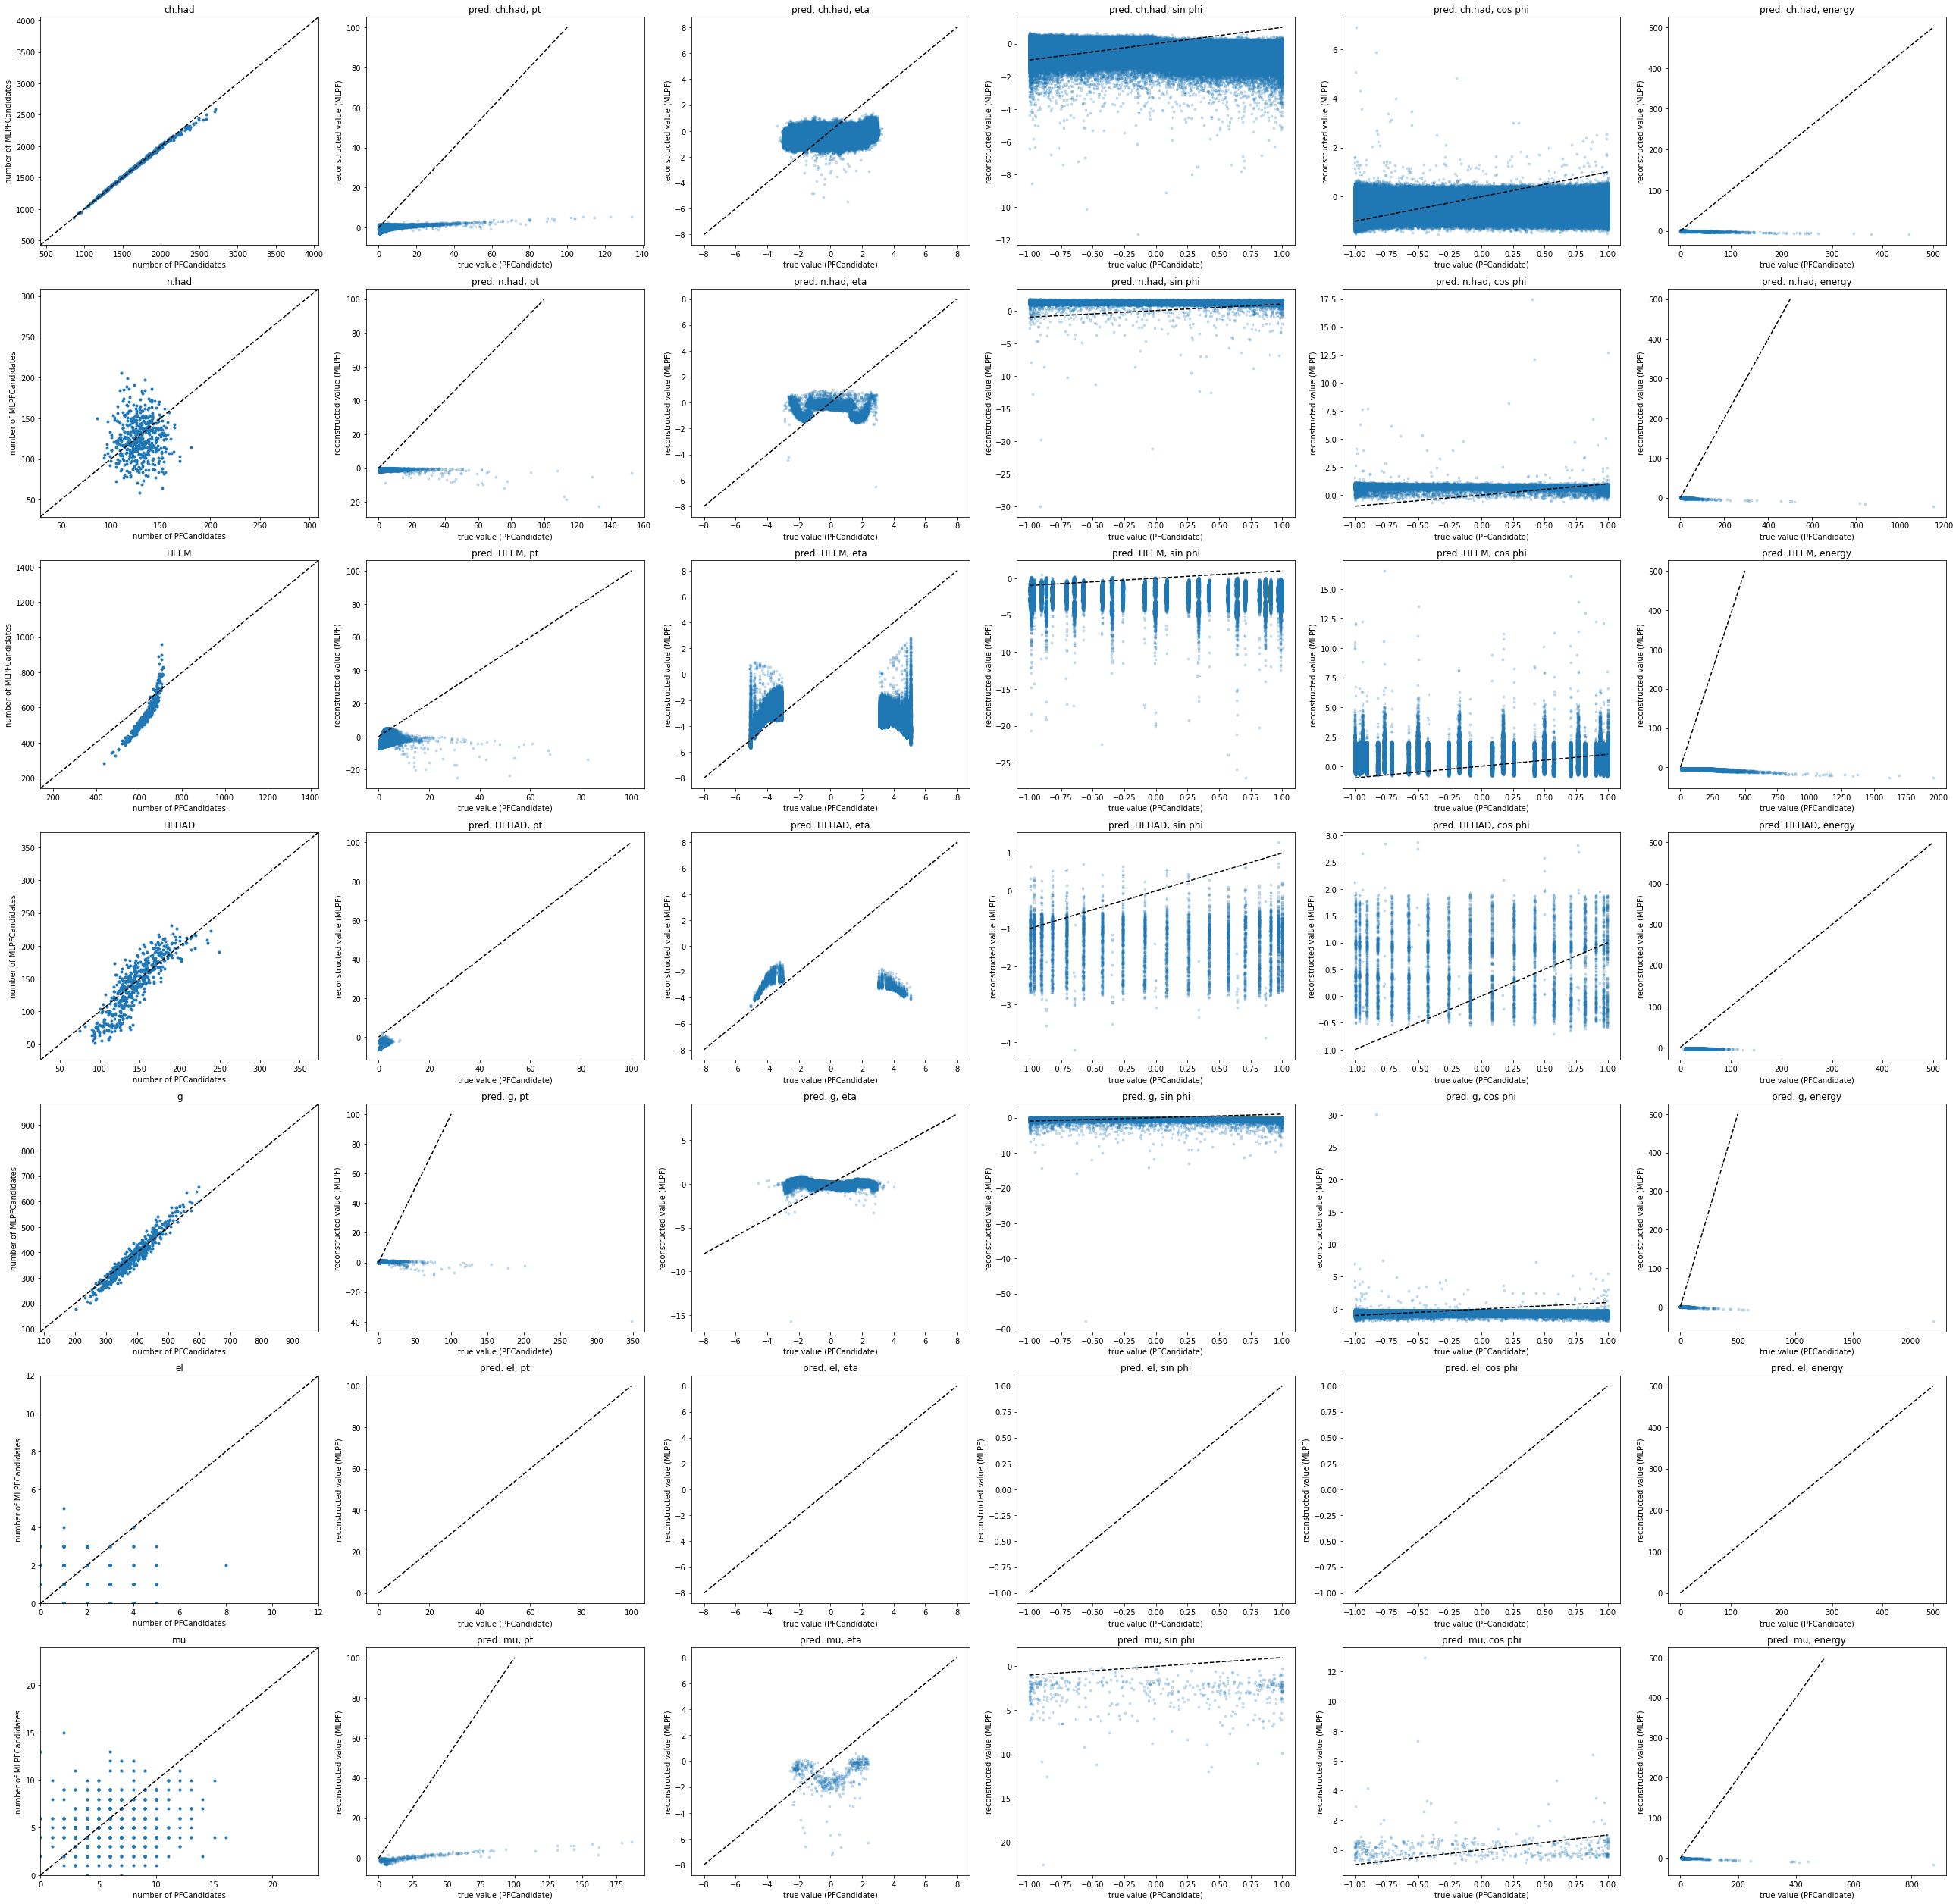

In [31]:
fig, axes = plt.subplots(7, 6, figsize=(6*6,7*5))

for axs, icls in zip(axes, range(1,8)):    
    axes = axs.flatten()
    
    npred = np.sum(ypred_id == icls, axis=1)
    ncand = np.sum(ycand[:, :, 0] == icls, axis=1)
    ngen = np.sum(ygen[:, :, 0] == icls, axis=1)
    
    a = 0.5*min(np.min(npred), np.min(ncand))
    b = 1.5*max(np.max(npred), np.max(ncand))
    
    axes[0].scatter(ncand, npred, marker=".")
    
    axes[0].set_xlim(a,b)
    axes[0].set_ylim(a,b)
    axes[0].plot([a,b],[a,b], color="black", ls="--")
    axes[0].set_title(pid_names[icls])
    axes[0].set_xlabel("number of PFCandidates")
    axes[0].set_ylabel("number of MLPFCandidates")
    
    msk_both = (ycand_f[:, 0]==icls) & (ypred_id_f==icls)
    print(icls, np.sum(msk_both))

    for ivar, ax in zip([2,3,4,5,6], axes[1:]):
        
#         hist = np.histogram2d(
#             ycand_f[msk_both, ivar],
#             ypred_f[msk_both, ivar], bins=(bins[ivar], bins[ivar])
#         )
#         norm = matplotlib.colors.Normalize(vmin=0, vmax=max(10, np.max(hist[0])))
#         if ivar == 2 or ivar == 6:
#             norm =  matplotlib.colors.LogNorm(vmin=1, vmax=max(10, 10*np.max(hist[0])))
#         hep.hist2dplot(
#             hist, cmap="Blues",
#             norm=norm,
#             ax=ax
#         )
        ax.scatter(ycand_f[msk_both, ivar], ypred_f[msk_both, ivar], marker=".", alpha=0.2)
        ax.plot([bins[ivar][0],bins[ivar][-1]], [bins[ivar][0], bins[ivar][-1]], color="black", ls="--")
        ax.set_title("pred. {}, {}".format(pid_names[icls], var_names[ivar]))
        ax.set_xlabel("true value (PFCandidate)")
        ax.set_ylabel("reconstructed value (MLPF)")
plt.tight_layout()
plt.savefig("full_performance.png", bbox_inches="tight", dpi=400)